# Examples

This Jupyter notebook shows examples for the different functions of the module `zaf`.

Functions:
- `stft` - [Short-time Fourier transform (STFT)](#stft)
- `istft` - [Inverse STFT](#istft)
- `cqtkernel` - [Constant-Q transform (CQT) kernel](#cqtkernel)
- `cqtspectrogram` - [CQT spectrogram using a CQT kernel](#cqtspectrogram)
- `cqtchromagram` - [CQT chromagram using a CQT kernel](#cqtchromagram)
- `mfcc` - [Mel frequency cepstrum coefficients (MFCCs)](#mfcc)
- `dct` - [Discrete cosine transform (DCT) using the fast Fourier transform (FFT)](#dct)
- `dst` - [Discrete sine transform (DST) using the FFT](#dst)
- `mdct` - [Modified discrete cosine transform (MDCT) using the FFT](#mdct)
- `imdct` - [Inverse MDCT using the FFT](#imdct)

Other:
- `wavread` - Read a WAVE file (using Scipy)
- `wavwrite` - Write a WAVE file (using SciPy)
- `sigplot` - Plot an audio signal in seconds
- `specshow` - Display an audio spectrogram in dB, seconds, and Hz
- `cqtspecshow` - Display a CQT audio spectrogram in dB, seconds, and Hz
- `cqtchromshow` - Display a CQT audio chromagram in seconds


Author:
-  Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 10/06/20

## <a id="stft"></a>Short-time Fourier transform (STFT)

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal [number_samples,]
    window_function: window function [window_length,]
    step_length: step length in samples
Output:
    audio_stft: audio STFT [window_length, number_frames]
```

### Example: compute and display the spectrogram from an audio file

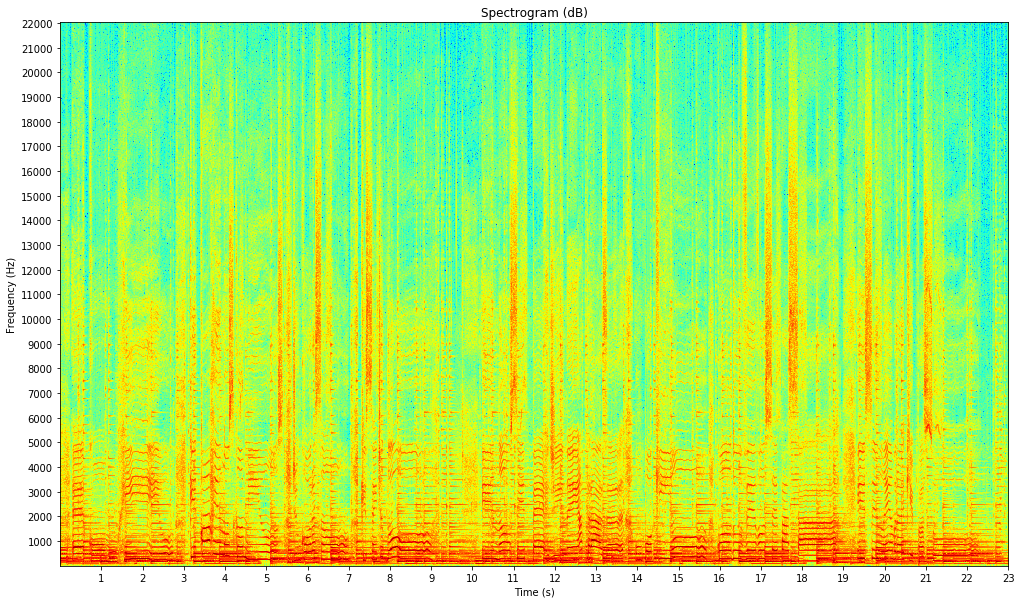

In [7]:
%matplotlib inline

# Import the modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')
audio_signal = np.mean(audio_signal, 1)

# Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04

# Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = pow(2, int(np.ceil(np.log2(window_duration * sampling_frequency))))

# Compute the window function (use SciPy's periodic Hamming window for COLA as NumPy's Hamming window is symmetric)
window_function = scipy.signal.hamming(window_length, False)

# Set the step length in samples (half of the window length for COLA)
step_length = int(window_length/2)

# Compute the STFT
audio_stft = zaf.stft(audio_signal, window_function, step_length)

# Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = np.absolute(audio_stft[1:int(window_length/2+1), :])

# Display the spectrogram in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.specshow(audio_spectrogram, len(audio_signal), sampling_frequency, xtick_step=1, ytick_step=1000)
plt.title("Spectrogram (dB)")
plt.show()

## <a id="istft"></a>Inverse short-time Fourier transform (STFT)

```
audio_signal = zaf.istft(audio_stft, window_function, step_length)

Inputs:
    audio_stft: audio STFT [window_length, number_frames]
    window_function: window function [window_length,]
    step_length: step length in samples
Output:
    audio_signal: audio signal [number_samples,]
```

### Example: estimate the center and the sides from a stereo audio file

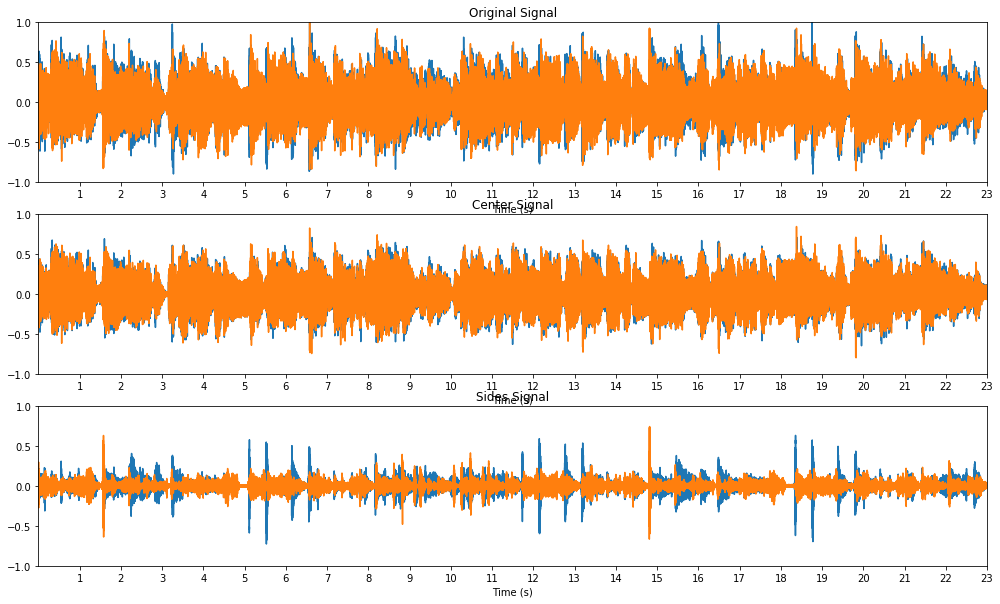

In [8]:
%matplotlib inline

# Import the modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the (stereo) audio signal with its sampling frequency in Hz
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')

# Set the parameters for the STFT
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
window_function = scipy.signal.hamming(window_length, False)
step_length = int(window_length/2)

# Compute the STFTs for the left and right channels
audio_stft1 = zaf.stft(audio_signal[:, 0], window_function, step_length)
audio_stft2 = zaf.stft(audio_signal[:, 1], window_function, step_length)

# Derive the magnitude spectrograms (with DC component) for the left and right channels
audio_spectrogram1 = abs(audio_stft1[0:int(window_length/2)+1, :])
audio_spectrogram2 = abs(audio_stft2[0:int(window_length/2)+1, :])

# Estimate the time-frequency masks for the left and right channels for the center
center_mask1 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram1
center_mask2 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram2

# Derive the STFTs for the left and right channels for the center (with mirrored frequencies)
center_stft1 = np.multiply(np.concatenate((center_mask1, center_mask1[int(window_length/2)-1:0:-1, :])), audio_stft1)
center_stft2 = np.multiply(np.concatenate((center_mask2, center_mask2[int(window_length/2)-1:0:-1, :])), audio_stft2)

# Synthesize the signals for the left and right channels for the center
center_signal1 = zaf.istft(center_stft1, window_function, step_length)
center_signal2 = zaf.istft(center_stft2, window_function, step_length)

# Derive the final stereo center and sides signals
center_signal = np.stack((center_signal1, center_signal2), axis=1)
center_signal = center_signal[0:len(audio_signal), :]
sides_signal = audio_signal-center_signal

# Write the center and sides signals
zaf.wavwrite(center_signal, sampling_frequency, 'center_file.wav')
zaf.wavwrite(sides_signal, sampling_frequency, 'sides_file.wav')

# Display the original, center, and sides signals in seconds
plt.figure(figsize=(17, 10))
plt.subplot(311),
zaf.sigplot(audio_signal, sampling_frequency, xtick_step=1), plt.ylim(-1, 1), plt.title("Original Signal")
plt.subplot(312)
zaf.sigplot(center_signal, sampling_frequency, xtick_step=1), plt.ylim(-1, 1), plt.title("Center Signal")
plt.subplot(313)
zaf.sigplot(sides_signal, sampling_frequency, xtick_step=1), plt.ylim(-1, 1), plt.title("Sides Signal")
plt.show()

## <a id="cqtkernel"></a>Constant-Q transform (CQT) kernel

```
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

Inputs:
    sampling_frequency: sampling frequency in Hz
    frequency_resolution: frequency resolution in number of frequency channels per semitone
    minimum_frequency: minimum frequency in Hz
    maximum_frequency: maximum frequency in Hz
Output:
    cqt_kernel: CQT kernel [number_frequencies, fft_length]
```

### Example: compute and display a CQT kernel

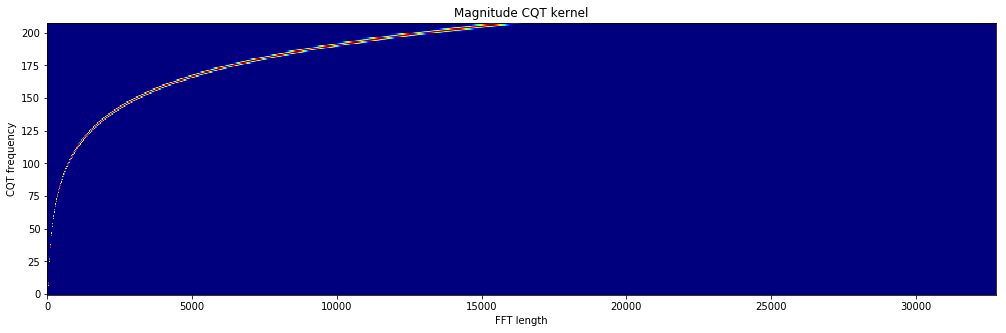

In [3]:
%matplotlib inline

# Import the modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Set the parameters for the CQT kernel
sampling_frequency = 44100
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = sampling_frequency/2

# Compute the CQT kernel
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Display the magnitude CQT kernel
plt.figure(figsize=(17,5))
plt.imshow(np.absolute(cqt_kernel).toarray(), aspect='auto', cmap='jet', origin='lower')
plt.title('Magnitude CQT kernel')
plt.xlabel('FFT length')
plt.ylabel('CQT frequency')
plt.show()

## <a id="cqtspectrogram"></a>Constant-Q transform (CQT) spectrogram using a CQT kernel

```
audio_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal [number_samples,]
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    cqt_kernel: CQT kernel [number_frequencies, fft_length]
Output:
    audio_spectrogram: magnitude audio spectrogram [number_frequencies, number_times]
```

### Example: compute and display the CQT spectrogram

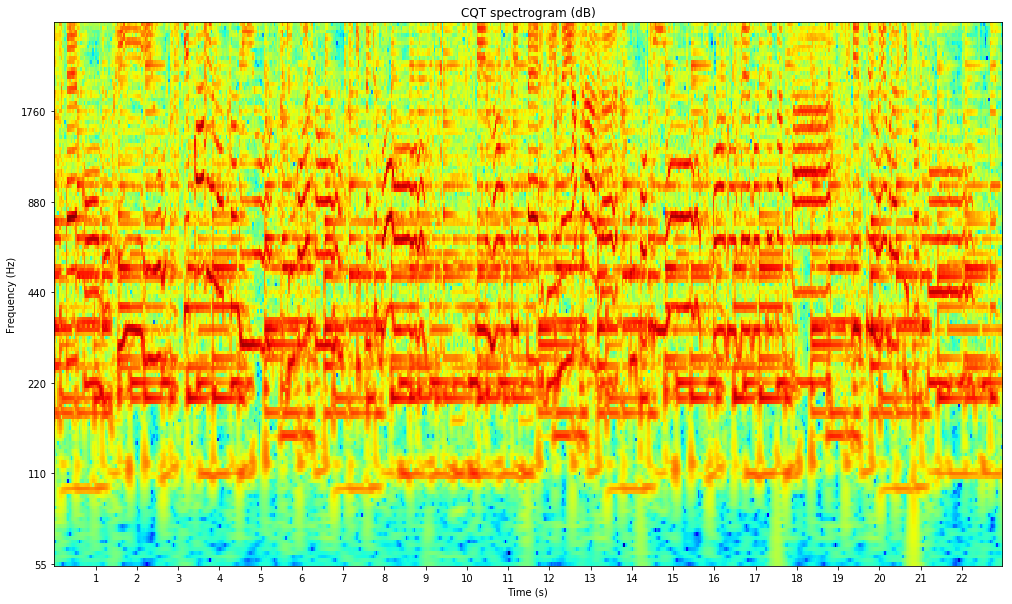

In [1]:
%matplotlib inline

# Import the modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')
audio_signal = np.mean(audio_signal, 1)

# Compute the CQT kernel using some parameters
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Compute the (magnitude) CQT spectrogram using the kernel
time_resolution = 25
audio_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

# Display the CQT spectrogram in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.cqtspecshow(audio_spectrogram, time_resolution, frequency_resolution, minimum_frequency, maximum_frequency, xtick_step=1)
plt.title("CQT spectrogram (dB)")
plt.show()

## <a id="cqtchromagram"></a>Constant-Q transform (CQT) chromagram using a CQT kernel

```
audio_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal [number_samples,]
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    frequency_resolution: frequency resolution in number of frequency channels per semitones
    cqt_kernel: CQT kernel [number_frequencies, fft_length]
Output
    audio_chromagram: audio chromagram [number_chromas, number_times]
```

### Example: compute and display the CQT chromagram

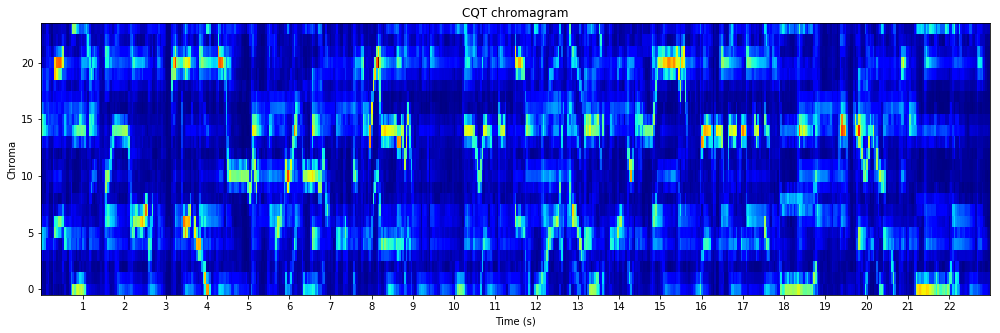

In [2]:
%matplotlib inline

# Import the modules
import scipy.io.wavfile
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')
audio_signal = np.mean(audio_signal, 1)

# Compute the CQT kernel using some parameters
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Compute the CQT chromagram
time_resolution = 25
audio_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

# Display the CQT chromagram in seconds
plt.figure(figsize=(17, 5))
zaf.cqtchromshow(audio_chromagram, time_resolution, xtick_step=1)
plt.title("CQT chromagram")
plt.show()

## <a id="mfcc"></a>Mel frequency cepstrum coefficients (MFCCs)

```
audio_mfcc = zaf.mfcc(audio_signal, sampling_frequency, number_filters, number_coefficients)

Inputs:
    audio_signal: audio signal [number_samples,]
    sampling_frequency: sampling frequency in Hz
    number_filters: number of filters
    number_coefficients: number of coefficients (without the 0th coefficient)
Output:
    audio_mfcc: audio MFCCs [number_times, number_coefficients]
```

### Example: compute and display the MFCCs, delta MFCCs, and delta-detla MFCCs

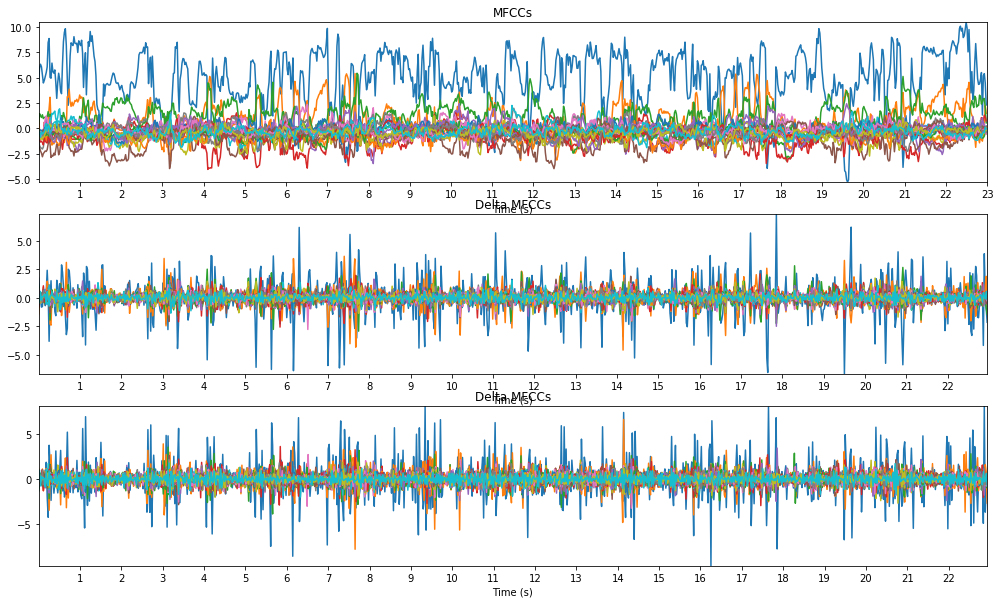

In [4]:
%matplotlib inline

# Import the modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')
audio_signal = np.mean(audio_signal, 1)

# Compute the MFCCs with a given number of filters and coefficients
number_filters = 40
number_coefficients = 20
audio_mfcc = zaf.mfcc(audio_signal, sampling_frequency, number_filters, number_coefficients)

# Compute the delta and delta-delta MFCCs
audio_dmfcc = np.diff(audio_mfcc, n=1, axis=1)
audio_ddmfcc = np.diff(audio_dmfcc, n=1, axis=1)

# Compute the time resolution for the MFCCs in number of time frames per second (~ sampling frequency for the MFCCs)
time_resolution = sampling_frequency * np.shape(audio_mfcc)[1] / len(audio_signal)

# Display the MFCCs, delta MFCCs, and delta-delta MFCCs in seconds
plt.figure(figsize=(17, 10))
plt.subplot(311),
zaf.sigplot(np.transpose(audio_mfcc), time_resolution, xtick_step=1), plt.title("MFCCs")
plt.subplot(312)
zaf.sigplot(np.transpose(audio_dmfcc), time_resolution, xtick_step=1), plt.title("Delta MFCCs")
plt.subplot(313)
zaf.sigplot(np.transpose(audio_ddmfcc), time_resolution, xtick_step=1), plt.title("Delta MFCCs")
plt.show()

## <a id="dct"></a>Discrete cosine transform (DCT) using the fast Fourier transform (FFT)

```
audio_dct = zaf.dct(audio_signal, dct_type)

Inputs:
    audio_signal: audio signal [number_samples, number_frames] (number_frames>0)
    dct_type: dct type (1, 2, 3, or 4)
Output:
    audio_dct: audio DCT [number_frequencies, number_frames]
```

### Example: compute the 4 different DCTs and compare them to SciPy's DCTs

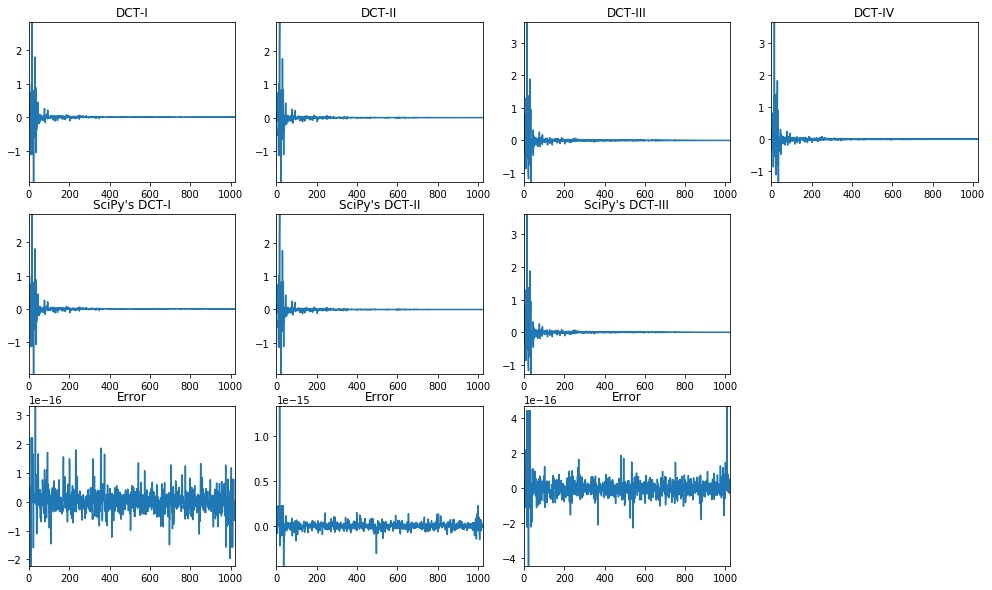

In [7]:
%matplotlib inline

# Import the modules
import numpy as np
import zaf
import scipy.fftpack
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread('audio_file.wav')
audio_signal = np.mean(audio_signal, 1)

# Get an audio segment for a given window length
window_length = 1024
audio_segment = audio_signal[0:window_length]

# Compute the DCT-I, II, III, and IV
audio_dct1 = zaf.dct(audio_segment, 1)
audio_dct2 = zaf.dct(audio_segment, 2)
audio_dct3 = zaf.dct(audio_segment, 3)
audio_dct4 = zaf.dct(audio_segment, 4)

# Comput SciPy's DCT-I (orthogonalized), II, and III (SciPy does not have a DCT-IV!)
audio_segment1 = np.concatenate((audio_segment[0:1]*np.sqrt(2), audio_segment[1:window_length-1],
                               audio_segment[window_length-1:window_length]*np.sqrt(2)), axis=0)
scipy_dct1 = scipy.fftpack.dct(audio_segment1, axis=0, type=1)
scipy_dct1[[0, window_length-1]] = scipy_dct1[[0, window_length-1]]/np.sqrt(2)
scipy_dct1 = scipy_dct1*np.sqrt(2/(window_length-1)) / 2
scipy_dct2 = scipy.fftpack.dct(audio_segment, axis=0, type=2, norm='ortho')
scipy_dct3 = scipy.fftpack.dct(audio_segment, axis=0, type=3, norm='ortho')

# Plot the DCT-I, II, III, and IV, SciPy's versions, and the errors
plt.figure(figsize=(17,10))
plt.subplot(3, 4, 1), plt.plot(audio_dct1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(3, 4, 2), plt.plot(audio_dct2), plt.autoscale(tight=True), plt.title("DCT-II")
plt.subplot(3, 4, 3), plt.plot(audio_dct3), plt.autoscale(tight=True), plt.title("DCT-III")
plt.subplot(3, 4, 4), plt.plot(audio_dct4), plt.autoscale(tight=True), plt.title("DCT-IV")
plt.subplot(3, 4, 5), plt.plot(scipy_dct1), plt.autoscale(tight=True), plt.title("SciPy's DCT-I")
plt.subplot(3, 4, 6), plt.plot(scipy_dct2), plt.autoscale(tight=True), plt.title("SciPy's DCT-II")
plt.subplot(3, 4, 7), plt.plot(scipy_dct3), plt.autoscale(tight=True), plt.title("SciPy's DCT-III")
plt.subplot(3, 4, 9), plt.plot(audio_dct1-scipy_dct1), plt.autoscale(tight=True), plt.title("Error")
plt.subplot(3, 4, 10), plt.plot(audio_dct2-scipy_dct2), plt.autoscale(tight=True), plt.title("Error")
plt.subplot(3, 4, 11), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("Error")
plt.show()

## <a id="dst"></a>Discrete sine transform (DST) using the fast Fourier transform (FFT)

```
audio_dst = zaf.dst(audio_signal, dst_type)

Inputs:
    audio_signal: audio signal [number_samples, number_frames] (number_frames>0)
    dst_type: DST type (1, 2, 3, or 4)
Output:
    audio_dst: audio DST [number_frequencies, number_frames]
```

### Example: compute the 4 different DSTs and compare them to their respective inverses

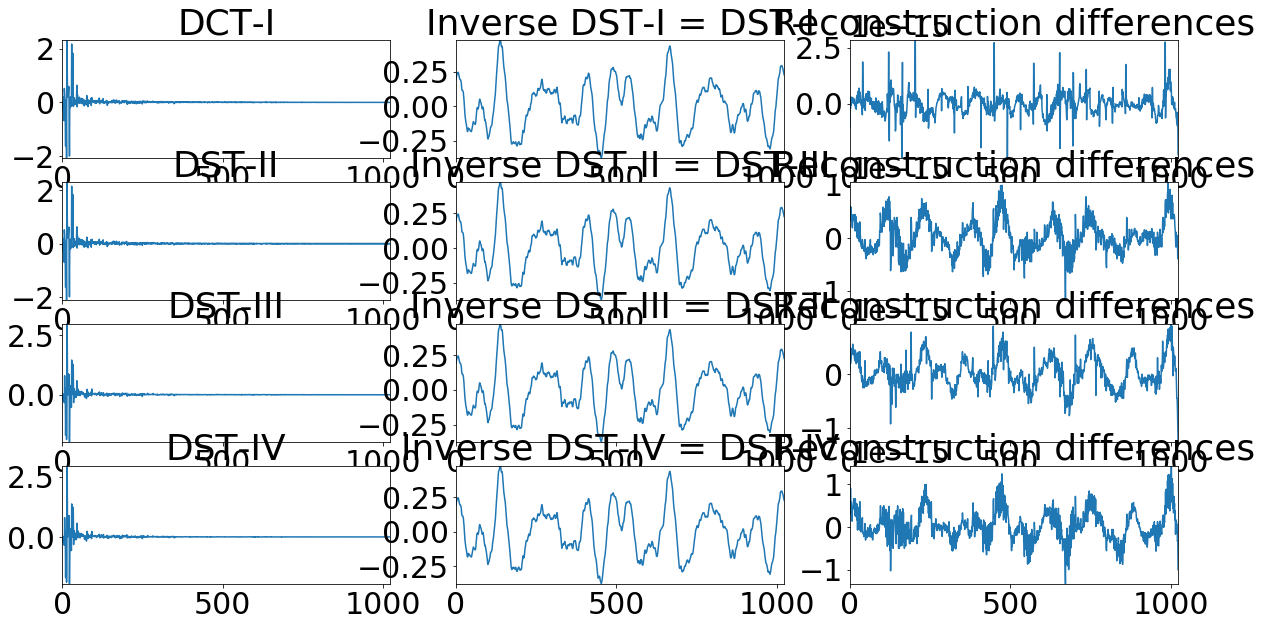

In [8]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import scipy.fftpack
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)
audio_signal = np.expand_dims(audio_signal, axis=1)

# Audio signal for a given window length, and one frame
window_length = 1024
audio_signal = audio_signal[0:window_length, :]

# DST-I, II, III, and IV
audio_dst1 = z.dst(audio_signal, 1)
audio_dst2 = z.dst(audio_signal, 2)
audio_dst3 = z.dst(audio_signal, 3)
audio_dst4 = z.dst(audio_signal, 4)

# Respective inverses, i.e., DST-I, II, III, and IV
audio_idst1 = z.dst(audio_dst1, 1)
audio_idst2 = z.dst(audio_dst2, 3)
audio_idst3 = z.dst(audio_dst3, 2)
audio_idst4 = z.dst(audio_dst4, 4)

# DST-I, II, III, and IV, respective inverses, and differences with the original signal displayed
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(4, 3, 1), plt.plot(audio_dst1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(4, 3, 2), plt.plot(audio_idst1), plt.autoscale(tight=True), plt.title("Inverse DST-I = DST-I")
plt.subplot(4, 3, 3), plt.plot(audio_signal-audio_idst1), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 4), plt.plot(audio_dst2), plt.autoscale(tight=True), plt.title("DST-II")
plt.subplot(4, 3, 5), plt.plot(audio_idst2), plt.autoscale(tight=True), plt.title("Inverse DST-II = DST-III")
plt.subplot(4, 3, 6), plt.plot(audio_signal-audio_idst2), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 7), plt.plot(audio_dst3), plt.autoscale(tight=True), plt.title("DST-III")
plt.subplot(4, 3, 8), plt.plot(audio_idst3), plt.autoscale(tight=True), plt.title("Inverse DST-III = DST-II")
plt.subplot(4, 3, 9), plt.plot(audio_signal-audio_idst3), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 10), plt.plot(audio_dst4), plt.autoscale(tight=True), plt.title("DST-IV")
plt.subplot(4, 3, 11), plt.plot(audio_idst4), plt.autoscale(tight=True), plt.title("Inverse DST-IV = DST-IV")
plt.subplot(4, 3, 12), plt.plot(audio_signal-audio_idst4), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.show()

## <a id="mdct"></a>Modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT)

```
audio_mdct = zaf.mdct(audio_signal, window_function)

Inputs:
    audio_signal: audio signal [number_samples,]
    window_function: window function [window_length,]
Output:
    audio_mdct: audio MDCT [number_frequencies, number_times]
```

### Example: compute and display the MDCT as in the AC-3 audio coding format

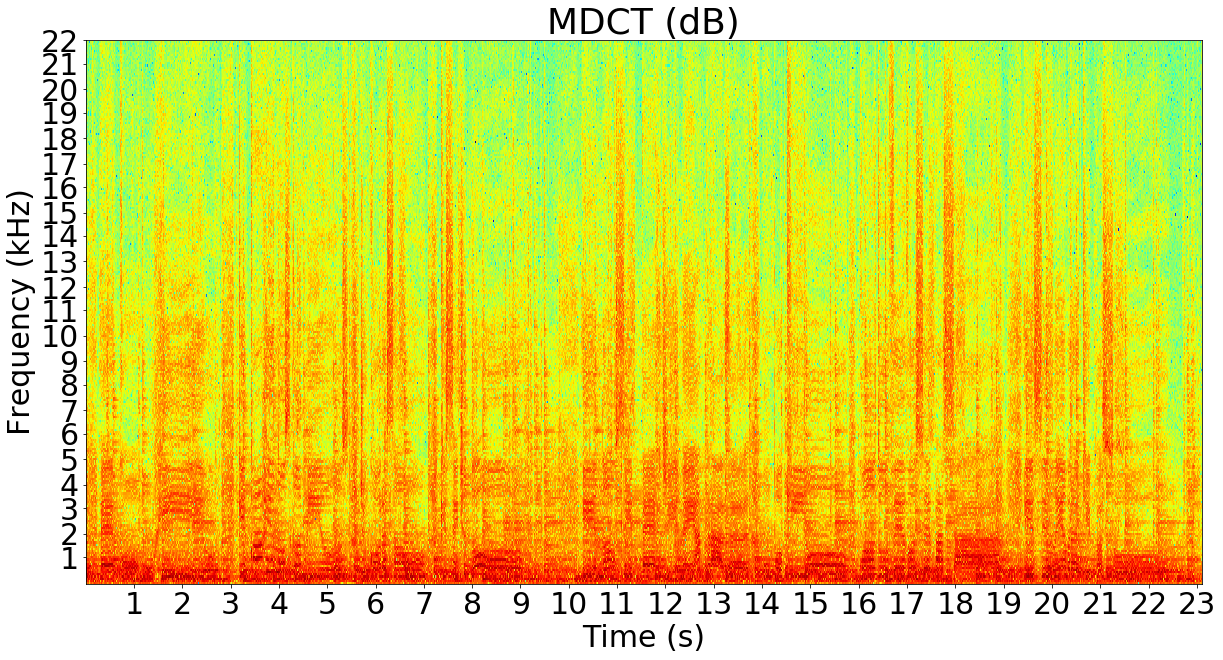

In [9]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# Kaiser-Bessel-derived (KBD) window as used in the AC-3 audio coding format
window_length = 512
alpha_value = 5
window_function = np.kaiser(int(window_length/2)+1, alpha_value*np.pi)
window_function2 = np.cumsum(window_function[1:int(window_length/2)])
window_function = np.sqrt(np.concatenate((window_function2, window_function2[int(window_length/2)::-1]))
                          / np.sum(window_function))

# MDCT
audio_mdct = z.mdct(audio_signal, window_function)

# MDCT displayed in dB, s, and kHz
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(20*np.log10(np.absolute(audio_mdct)), aspect='auto', cmap='jet', origin='lower')
plt.title('MDCT (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/(window_length/2)),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.round(np.arange(1e3, sample_rate/2+1, 1e3)/sample_rate*window_length),
           np.arange(1, int(sample_rate/2*1e3)+1))
plt.ylabel('Frequency (kHz)')
plt.show()

## <a id="imdct"></a>Inverse modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT)

```
audio_signal = zaf.imdct(audio_mdct, window_function)

Inputs:
    audio_mdct: audio MDCT [number_frequencies, number_times]
    window_function: window function [window_length,]
Output:
    audio_signal: audio signal [number_samples,]
```

### Example: verify that the MDCT is perfectly invertible

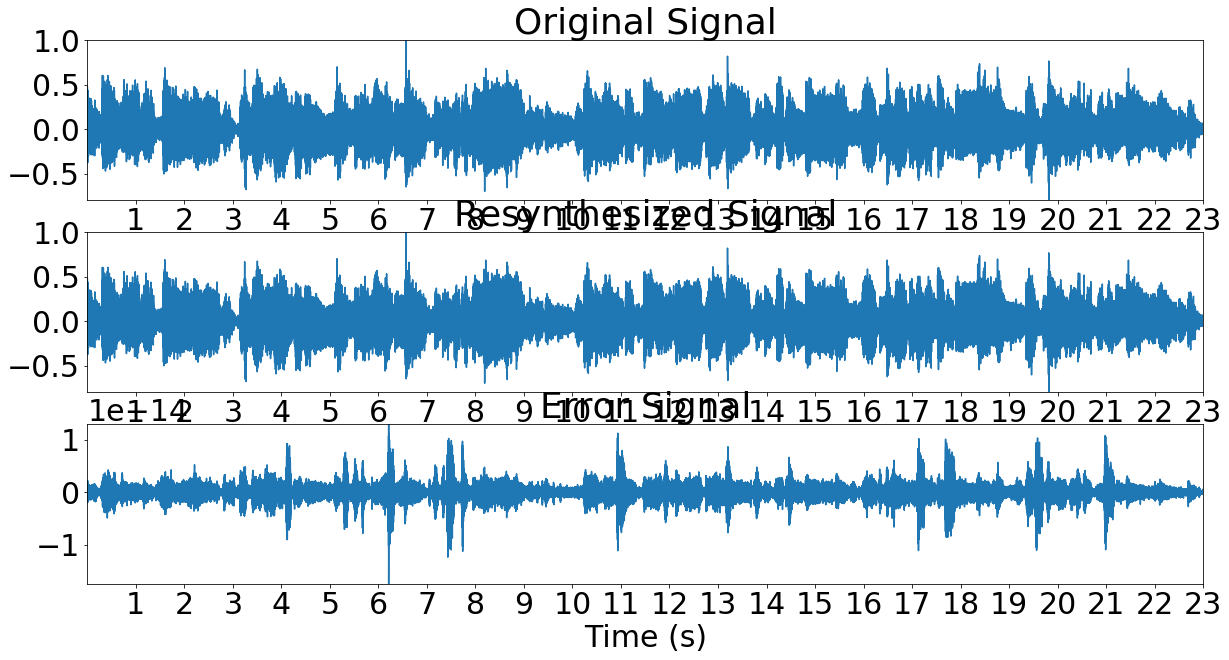

In [11]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0 ** (audio_signal.itemsize * 8 - 1))
audio_signal = np.mean(audio_signal, 1)

# MDCT with a slope function as used in the Vorbis audio coding format
window_length = 2048
window_function = np.sin(np.pi / 2
                         * np.power(np.sin(np.pi / window_length * np.arange(0.5, window_length + 0.5)), 2))
audio_mdct = z.mdct(audio_signal, window_function)

# Inverse MDCT and error signal
audio_signal2 = z.imdct(audio_mdct, window_function)
audio_signal2 = audio_signal2[0:len(audio_signal)]
error_signal = audio_signal - audio_signal2

# Original, resynthesized, and error signals
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(3, 1, 1), plt.plot(audio_signal), plt.autoscale(tight=True), plt.title("Original Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 2), plt.plot(audio_signal2), plt.autoscale(tight=True), plt.title("Resynthesized Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 3), plt.plot(error_signal), plt.autoscale(tight=True), plt.title("Error Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.show()